In [22]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties 
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings("ignore")   
from collections import Counter

In [9]:
import fastf1

# Enable FastF1 cache
fastf1.Cache.enable_cache(r"D:\PYTON PROGRAMMING\CACHE")

# Load session
session = fastf1.get_session(2025, 'austria', 'Race')  
session.load()

# Get the laps data
df = session.laps
results = session.results.sort_values(by='Abbreviation')

# Load Font 
bold_font = FontProperties(fname=r"D:\PYTON PROGRAMMING\PYTHON FILES\Data-Visualization-Using-Python\STREAMLIT & PANEL\F1 RACE ANALYSIS PROJECTS\F1 Font\Formula1-Bold_web_0.ttf")
regular_font = FontProperties(fname=r"D:\PYTON PROGRAMMING\PYTHON FILES\Data-Visualization-Using-Python\STREAMLIT & PANEL\F1 RACE ANALYSIS PROJECTS\F1 Font\Formula1-Regular_web_0.ttf")

core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '16', '44', '63', '30', '14', '5', '27', '31', '87', '6', '10', '18', '43', '22', '23', '1', '12', '55']


## Race Position Lap by Lap

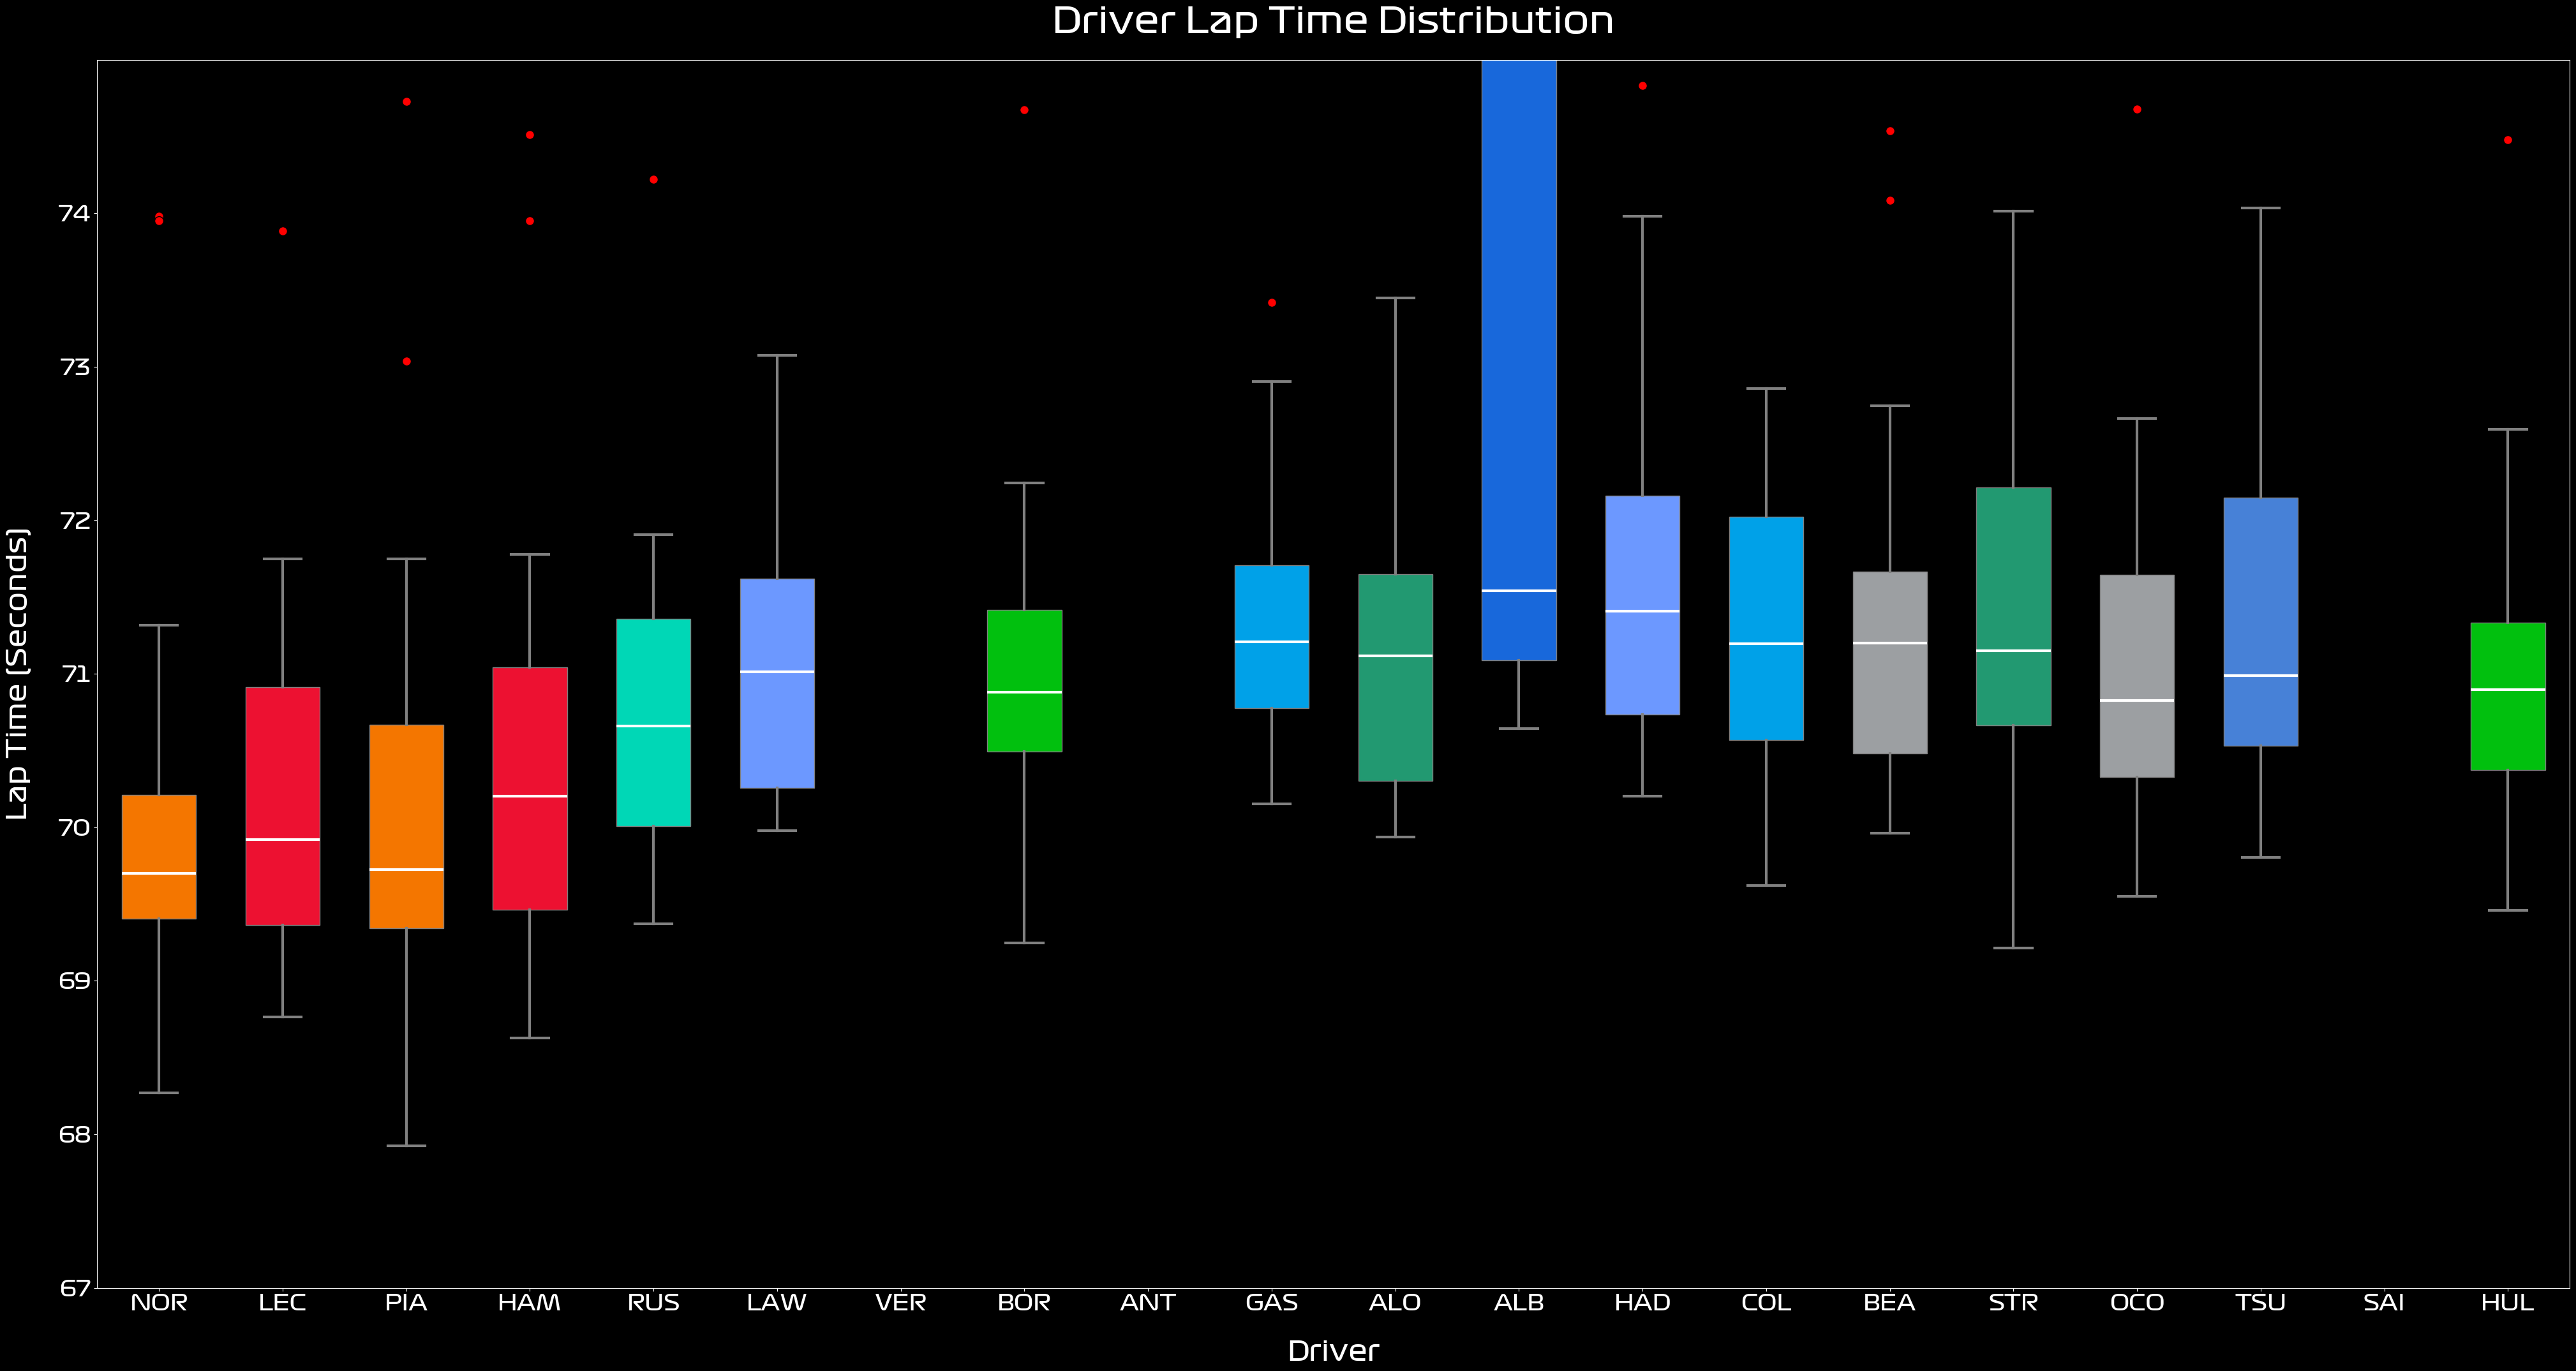

In [ ]:
class LapTimeAnalysis:
    def __init__(self, df, driver_1, driver_2, results_df, font):
        self.df = df
        self.driver_1 = driver_1.upper()
        self.driver_2 = driver_2.upper()
        self.results_df = results_df
        self.font = font
        
        self.df['Seconds'] = pd.to_timedelta(df['LapTime']).dt.total_seconds()
        
        self.drv1_tel_data = self.df.pick_driver(self.driver_1.upper()).get_telemetry().add_distance()
        self.drv1_data = self.df.pick_driver(self.driver_1.upper())
        self.drv1_color = "#" + str(self.results_df[self.results_df['Abbreviation'] == self.driver_1.upper()]['TeamColor'].values[0])
        
        self.drv2_tel_data = self.df.pick_driver(self.driver_2.upper()).get_telemetry().add_distance()    
        self.drv2_data = self.df.pick_driver(self.driver_2.upper())
        self.drv2_color = "#" + str(self.results_df[self.results_df['Abbreviation'] == self.driver_2.upper()]['TeamColor'].values[0])
        if self.drv1_color == self.drv2_color:
            self.drv2_color = "#8D006A"

        self.drv1_laptime = self.drv1_data['Seconds'].tolist()  
        
        # Bit of data cleaning and manipulation
        self.results_df.sort_values(by='Abbreviation')[['Abbreviation', 'TeamColor']]
        pivot_df = self.df.pivot_table(index='Driver', columns='LapNumber', values='Position')
        req_col = self.results_df[['Abbreviation', 'TeamColor', 'DriverNumber', 'TeamName', 'GridPosition']].reset_index(drop=True)

        # Reset index of the first table to make Driver a column
        pivot_df_reset = pivot_df.reset_index()

        # Merge with the second table
        new_df = pd.merge(req_col, pivot_df_reset, left_on='Abbreviation', right_on='Driver', how='left')
        self.new_df = new_df.drop(columns=['Driver']).sort_values(by='GridPosition', ascending=True)
        
    def get_overall_track_positions(self):
        fig, ax = plt.subplots(figsize=(60, 30))

        # Set the background color of the entire figure canvas to black.
        fig.patch.set_facecolor('black')    # .patch is the rectangle that is the background of the figure.
                                        
        # Set plot (axes) background color to black
        ax.set_facecolor('black')

        # Set axis labels and tick color to white
        ax.tick_params(colors='white')         # .tick_params(...)	Customizes tick appearance
        ax.xaxis.label.set_color('white')      # X-axis label color
        ax.yaxis.label.set_color('white')      # ax, the plot area (Axes object)
        ax.title.set_color('white')

        # Make the axis color white
        for spine in ax.spines.values():       # It changes the color of all four border lines (called spines) around your plot to white.
            spine.set_color('white')

        # Plot the data
        for idx, row in self.new_df.iterrows():
            driver = row['Abbreviation']
            
            # Safely get team color (handle float values)
            try:
                color_str = str(row['TeamColor'])
                # Remove decimal point if present (e.g., convert "229971.0" to "229971")
                color_str = color_str.split('.')[0] if '.' in color_str else color_str
                color_code = f"#{color_str}"
            except (KeyError, AttributeError):
                color_code = "#FAF5F5"  # fallback color
            
            # Get lap position data (columns from 5th onward)
            lap_data = row.iloc[4:].values  # Skip first 4 columns (index, Abbreviation, TeamColor, DriverNumber)
            
            ax.plot(
                np.arange(1, len(lap_data) + 1),  # Lap numbers starting at 1
                lap_data,
                color=color_code,
                linewidth=4
            )

        # Set axis limits
        x_max = ( self.new_df.shape[1] - 4 )     # We are skipping the first 4 columns

        plt.xticks(range(0,int(x_max),2))
        plt.yticks(range(1,21))

        plt.xlim(-2, int(x_max) + 2)

        for label in ax.get_xticklabels():
            label.set_fontproperties(self.font)
            label.set_fontsize(25)

        for label in ax.get_yticklabels():
            label.set_fontproperties(self.font)
            label.set_fontsize(25)
            
        ax.set_yticklabels(self.new_df['Abbreviation'].tolist())
            
        ax.grid(axis='y', linestyle='-', alpha=0.6)

        for y_value in ax.get_yticks().tolist():
            ax.text(72, y_value, 'F', ha='left', va='center', fontsize=25, color='white')

        ax.invert_yaxis()

        plt.title('F1 Canadian GP 2025', fontproperties=bold_font, fontsize = 40, color = 'r', pad=40)
        
        return fig  

    def get_net_postition_gain_loss(self):
        fig, ax = plt.subplots(figsize=(50, 25))  
        fig.set_facecolor('black')
        ax.set_facecolor('black')  
        ax.tick_params(axis='x',colors='white')
        plt.yticks([])

        for tick in ax.get_xticklabels():
            tick.set_fontproperties(regular_font)
            tick.set_fontsize(25)

        for driver in self.new_df['Abbreviation'].tolist():
            driver_row = self.new_df[self.new_df['Abbreviation'] == driver]

            # Get positions - convert to scalar values using .item()
            start_pos = driver_row['GridPosition'].item()  # Gets single value
            last_col_value = driver_row.iloc[0,-1]         # Gets single value
            second_last_col = driver_row.iloc[0,-2]        # Gets single value

            # Choose end position ( If driver got lapped then choose the second last value)
            end_pos = last_col_value if not pd.isna(last_col_value) else second_last_col
            
            if pd.isna(end_pos):
                diff = start_pos - 20       # If the final value is NaN, subtract 20 instead
            else:
                diff = start_pos - end_pos
                
            try :
                color_code = "#" + str(results.loc[results['Abbreviation'] == driver, 'TeamColor'].values[0])
            except IndexError:
                color_code = "#FAF5F5"  # fallback color
                
            ax.bar(x = driver, height=diff, color=color_code, width=0.5)
            if diff > 0:
                ax.text(
                    driver, 
                    diff + 0.3, 
                    int(diff),
                    color = 'white', 
                    fontsize = 25,
                    fontproperties = regular_font, 
                    ha = 'center', 
                    va = 'center'
                )
            else:
                ax.text(
                    driver, 
                    diff - 0.3, 
                    int(diff),
                    color = 'white', 
                    fontsize = 25, 
                    fontproperties = regular_font,
                    ha = 'center', 
                    va = 'center'
                )

        ax.tick_params(colors='white')
        ax.axhline(y=0, color='red', linestyle='-')
        
        return fig
    
    def box_plot_analysis(self):
        fig, ax = plt.subplots(figsize=(50, 25))
        fig.set_facecolor('black')
        ax.set_facecolor('black')
        ax.tick_params(axis='both', colors='white')

        # Set font properties for ticks
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontproperties(regular_font)
            tick.set_fontsize(25)

        # Set spine colors
        for spine in ax.spines.values():
            spine.set_color('white')

        # Prepare data
        drivers = self.new_df['Abbreviation'].tolist()
        positions = range(len(drivers))  # Use sequential positions

        drv_iqr_min = []
        drv_iqr_max = []
        # Plot boxplots
        for i, driver in enumerate(drivers):
            drv_data = self.df.pick_driver(driver)
            color = '#' + str(self.new_df.loc[self.new_df['Abbreviation'] == driver, 'TeamColor'].values[0])
            ax.boxplot(
                drv_data['Seconds'],
                positions=[i],
                widths=0.6,
                patch_artist=True,
                boxprops=dict(facecolor=color, color='gray'),
                whiskerprops=dict(color='gray', linewidth=3),
                capprops=dict(color='gray', linewidth=3),
                medianprops=dict(color='white', linewidth=3),
                flierprops=dict(markerfacecolor='red', marker='o', markersize=10, linestyle='none')
            )
            # For Y Axis Range Calculation - Proper NaN handling
            clean_seconds = drv_data['Seconds'].dropna()  # Remove NaN values first
            
            if not clean_seconds.empty:  # Check if we have any data left
                q1 = int(clean_seconds.quantile(0.25))
                q3 = int(clean_seconds.quantile(0.75))
            else:
                continue
            
            iqr_min = float((q1) - 1.5 * (q3 - q1))  # Lower bound for outliers
            iqr_max = float((q3) + 1.5 * (q3 - q1))  # Upper bound for outliers
            
            drv_iqr_min.append(iqr_min)
            drv_iqr_max.append(iqr_max)
        
        drv_iqr_max_commons = Counter(drv_iqr_max)
        modes_max = [k for k, v in drv_iqr_max_commons.items() if v == max(drv_iqr_max_commons.values())]       # Dealing with case if there is multiple values with same number of tiems 
        unique_max = max(modes_max)
        
        drv_iqr_min_vc = Counter(drv_iqr_min)
        modes_min = [k for k, v in drv_iqr_min_vc.items() if v == max(drv_iqr_min_vc.values())]       # Dealing with case if there is multiple values with same number of tiems 
        unique_min = min(modes_min)   
        
        y_min = (int(unique_min) - 0.6) 
        y_max = (int(unique_max) + 3)

        # Set y-axis limits and ticks
        ax.set_ylim(y_min , y_max)
        ax.set_yticks(range(int(y_min), int(y_max)))

        # Set x-ticks and labels after plotting
        ax.set_xticks(positions)
        ax.set_xticklabels(drivers, fontproperties=regular_font, fontsize=25)

        # Optional: Add labels
        ax.set_xlabel("Driver", fontproperties=self.font, fontsize=30, color='white', labelpad=30)
        ax.set_ylabel("Lap Time (Seconds)", fontproperties=self.font, fontsize=30, color='white', labelpad=30)
        ax.set_title("Driver Lap Time Distribution", fontproperties=self.font, fontsize=40, color='white', pad=30)

        return fig

    def __assign_and_clean_telemetry(self, data_df, telemetry_df):
        
        data_df['LapStartTime'] = data_df['LapStartTime'].astype('timedelta64[ns]')
        data_df['LapTime'] = data_df['LapTime'].astype('timedelta64[ns]')
        data_df['LapEndTime'] = data_df['LapStartTime'] + data_df['LapTime']
        lap_numbers = []

        for index, row in telemetry_df.iterrows():
            lap_found = False
            for _, lap in data_df.iterrows():
                if lap['LapStartTime'] <= row['SessionTime'] <= lap['LapEndTime']:
                    lap_numbers.append(lap['LapNumber'])
                    lap_found = True
                    break
            if not lap_found:
                lap_numbers.append(None)

        telemetry_df['LapNumber'] = lap_numbers
                
        # 1. Select only the required columns
        selected_cols = ['LapNumber', 'X', 'Speed', 'nGear', 'Brake', 'RPM', 'Throttle']
        filtered_df = telemetry_df[selected_cols].copy()

        # 2. Define function to drop rows with very close X values within a lap
        def drop_close_x_rows(filtered_df, tolerance=0.01):
            cleaned_rows = []
            prev_x = None
            for _, row in filtered_df.iterrows():
                x = row['X']
                if prev_x is None or abs(x - prev_x) > tolerance:
                    cleaned_rows.append(row)
                    prev_x = x
            return pd.DataFrame(cleaned_rows)

        # 3. Apply function to each lap group
        cleaned_tel_df = (
            filtered_df
            .groupby('LapNumber', group_keys=False)
            .apply(drop_close_x_rows)
        )

        # 4. Sort by LapNumber and X
        cleaned_tel_df = cleaned_tel_df.sort_values(['LapNumber', 'X']).reset_index(drop=True)
        return telemetry_df  
    
    def get_sector_time_comparison(self):
        drv1_laptime = self.drv1_data['Seconds'].tolist()
        drv2_laptime = self.drv2_data['Seconds'].tolist()
        
        fig, ax = plt.subplots(figsize=(50, 25))
        fig.set_facecolor('#1C1C2A')
        ax.set_facecolor('#1C1C2A')
        
        ax.plot(self.drv1_data['LapNumber'].tolist(), drv1_laptime, color=self.drv1_color, linewidth=2)
        ax.plot(self.drv2_data['LapNumber'].tolist(), drv2_laptime, color=self.drv2_color, linewidth=2)

        ax.set_title(f"{self.driver_1} vs {self.driver_2} Lap Times", fontproperties = self.font, fontsize=50, color='red', pad=20)
         
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontproperties(self.font)  
            label.set_color("white")
            
        for spine in ax.spines.values():
            spine.set_visible(False)
           
        ax.set_xlabel("Lap Number", fontproperties = self.font, fontsize=25, color='white', labelpad=20)
        ax.set_ylabel("Lap Time (s)", fontproperties = self.font, fontsize=25, color='white', labelpad=20)               
        ax.tick_params(axis='both', colors='white', labelsize=25)  # X and Y-axis tick labels
        
        ax.set_ylim(74, 80)
        ax.legend([self.driver_1, self.driver_2])
        ax.grid(True, alpha=0.2)
        
        return fig
    
    def get_average_lap_speed(self):
                
        drv1_tel_data = self.__assign_and_clean_telemetry(self.drv1_data, self.drv1_tel_data)
        drv2_tel_data = self.__assign_and_clean_telemetry(self.drv2_data, self.drv2_tel_data)
        
        drv1_avg_speed = drv1_tel_data.groupby('LapNumber')['Speed'].mean().reset_index()
        drv2_avg_speed = drv2_tel_data.groupby('LapNumber')['Speed'].mean().reset_index()
        
        fig, ax = plt.subplots(figsize=(50, 20))
        fig.set_facecolor('#1C1C2A')
        ax.set_facecolor('#1C1C2A')
         
        # Plot the data
        ax.plot(drv1_avg_speed['LapNumber'], drv1_avg_speed['Speed'], color=self.drv1_color, linewidth=5)
        ax.plot(drv2_avg_speed['LapNumber'], drv2_avg_speed['Speed'], color=self.drv2_color, linewidth=5)
        ax.fill_between(drv2_avg_speed['LapNumber'], drv2_avg_speed['Speed'], drv1_avg_speed['Speed'], color='#A5DDFF', alpha = 0.5)

        ax.set_title(f"{self.driver_1} vs {self.driver_2} Average Lap Speed", fontproperties = self.font, fontsize=30, weight='bold', color='red', pad=20) 
        
        ax.tick_params(axis='both', colors='white', labelsize=30)  # X and Y-axis tick labels
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontproperties(self.font)
            tick.set_fontsize(20)
            
        # Remove border spines
        for spine in ax.spines.values():
            spine.set_visible(False)
            
        ax.set_xticks(range(1, 71, 2))
        ax.set_xlabel("Lap Number", fontsize=20, fontproperties = self.font, color = 'white', labelpad=20)
        ax.set_ylabel("Average Speed (kM/H)", fontsize=20, fontproperties = self.font, color = 'white', labelpad=20)
        ax.set_xlim(0, 72)
        ax.set_ylim(150, 220)
        
        ax.legend([self.driver_1, self.driver_2], fontsize=20, loc='upper left', bbox_to_anchor=(1, 1), prop = self.font)
        ax.grid(True, alpha=0.5)
        ax.grid(False, axis='x')
        
        return fig
    
    def overall_laptime_dominance(self):
        drv1_faster = 0
        drv2_faster = 0 
        drv1_counts = {'SOFT': 0, 'MEDIUM': 0, 'HARD': 0, 'INTERMEDIATE': 0, 'WET': 0}
        drv2_counts = {'SOFT': 0, 'MEDIUM': 0, 'HARD': 0, 'INTERMEDIATE': 0, 'WET': 0}
        compound_colors = {
                'SOFT': '#FF3333',         # Red
                'MEDIUM': '#FFFF00',       # Yellow
                'HARD': '#FFFFFF',         # White
                'INTERMEDIATE': '#00FF00', # Green
                'WET': '#0000FF'           # Blue
            }

        for (_, drv1), (_, drv2) in zip(self.drv1_data.iterrows(), self.drv2_data.iterrows()):
            if drv1['Seconds'] < drv2['Seconds']:
                drv1_faster += 1
                compound = drv1['Compound']
                if compound in drv1_counts:
                    drv1_counts[compound] += 1
            elif drv1['Seconds'] > drv2['Seconds']:
                drv2_faster += 1
                compound = drv2['Compound']
                if compound in drv2_counts:
                    drv2_counts[compound] += 1
                
        fig, ax = plt.subplots(figsize=(5, 5))
        fig.set_facecolor('#1C1C2A')
        ax.set_facecolor('#1C1C2A')
        
        # Plot Pie
        labels = [f"{self.driver_1} : {drv1_faster}", f"{self.driver_2} : {drv2_faster}"]
        size = 0.3
        wedge, texts =ax.pie([drv1_faster, drv2_faster], 
                             labels=labels, colors=[self.drv1_color, self.drv2_color], startangle=90,
                             wedgeprops=dict(width=size, edgecolor='w', linewidth=1.5)
                        )
        for text in texts:
            text.set_fontproperties(self.font)
            text.set_color('white')         
            text.set_fontsize(12)           
            text.set_weight('bold')         
            
        # Construct inner labels
        compound_order = list(drv1_counts.keys()) * 2  # ['SOFT', ..., 'WET', 'SOFT', ..., 'WET']
        combined_tyre_data = list(drv1_counts.values()) + list(drv2_counts.values())

        # Filter out zero lap entries and store compound info
        filtered_data = []
        for driver_idx, outer_value in enumerate([drv1_faster, drv2_faster]):
            for i, (value, compound) in enumerate(zip(
                combined_tyre_data[driver_idx * len(drv1_counts):(driver_idx + 1) * len(drv1_counts)],
                compound_order[driver_idx * len(drv1_counts):(driver_idx + 1) * len(drv1_counts)]
            )):
                if value > 0:
                    filtered_data.append((value, compound))

        # Extract inner ring details
        inner_values = []
        inner_labels = []
        inner_colors = []

        for value, compound in filtered_data:
            inner_values.append(value)
            inner_labels.append(f"{value}")  # 👉 show lap count instead of percentage
            inner_colors.append(compound_colors[compound])

        # Draw the inner pie chart
        wedges, labels = ax.pie(
            inner_values,
            radius=1 - size,
            labels=inner_labels,
            labeldistance=0.8,
            wedgeprops=dict(width=size, edgecolor='white', linewidth=1.5),
            colors=inner_colors,
            startangle=90
        )
        for text in labels :
            text.set_fontproperties(self.font)
            text.set_color('black')         
            text.set_fontsize(12)           
            text.set_weight('bold') 
        # Fix inner label position
        for string_label in labels:
            string_label.update({"rotation": 0, "horizontalalignment": "center", "verticalalignment": "center"})

        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        ax.set_title(f"{self.driver_1} vs {self.driver_2} Number Of Laps Dominance", fontproperties = self.font, fontsize=15, weight='bold', color='red', pad=20)
        
        return fig

    def lap_telemtry_comparision(self, lapnumber, data):
        # Prepare telemetry data with cleaned and assigned lap numbers
        try:
            drv1_lap_data = self.drv1_data[self.drv1_data['LapNumber'] == lapnumber]
            drv2_lap_data = self.drv2_data[self.drv2_data['LapNumber'] == lapnumber]
            
            if len(drv1_lap_data) == 0 or len(drv2_lap_data) == 0:
                raise ValueError(f"Lap {lapnumber} not found for one or both drivers")
                
        except KeyError:
            raise KeyError("'LapNumber' column missing in data")  # Stop if column doesn't exist
                    
        drv1_tel_data = drv1_lap_data.get_telemetry()
        drv2_tel_data = drv2_lap_data.get_telemetry()

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(50, 20))
        fig.set_facecolor('#1C1C2A')
        ax.set_facecolor('#1C1C2A')

        # Plot both drivers’ data
        ax.plot(drv1_tel_data['Distance'], drv1_tel_data[data], color=self.drv1_color, linewidth=5, label=self.driver_1)
        ax.plot(drv2_tel_data['Distance'], drv2_tel_data[data], color=self.drv2_color, linewidth=5, label=self.driver_2)

        # Tick customization
        ax.tick_params(axis='both', colors='white', labelsize=20)
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontproperties(self.font)
            tick.set_fontsize(20)

        # Remove border spines
        for spine in ax.spines.values():
            spine.set_visible(False)

        # Axis labels
        ax.set_xlabel("Distance", fontsize=30, fontproperties=self.font, color='#C5EBFF', labelpad=20)
        ax.set_ylabel(data, fontsize=30, fontproperties=self.font, color='#C5EBFF', labelpad=20)

        ax.set_xticks(range(0, 5000, 500))
        # Title
        ax.set_title(f"{data} Analysis - Lap {lapnumber}", fontproperties=self.font, fontsize=35, color='red', pad=30)

        # Grid setup
        ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
        ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.3, alpha=0.3)
        ax.minorticks_on()

        # Legend
        ax.legend(
            prop=self.font,
            fontsize=30,         # Text size
            loc='upper right',   # Legend position
            markerscale=2,       # Size of marker icons
            handlelength=3,      # Length of the legend lines
            borderpad=1.5,       # Padding inside the legend box
            frameon=True,        # Show the box
            labelspacing=1.2     # Vertical space between labels
        )

        return fig
    
    def track_dominance(self, lapnumber):
        # Prepare telemetry data with cleaned and assigned lap numbers
        try:
            drv1_lap_data = self.drv1_data[self.drv1_data['LapNumber'] == lapnumber]
            drv2_lap_data = self.drv2_data[self.drv2_data['LapNumber'] == lapnumber]
            
            if len(drv1_lap_data) == 0 or len(drv2_lap_data) == 0:
                raise ValueError(f"Lap {lapnumber} not found for one or both drivers")
                
        except KeyError:
            raise KeyError("'LapNumber' column missing in data")  # Stop if column doesn't exist
                
        drv1_tel_data = drv1_lap_data.get_telemetry()
        drv2_tel_data = drv2_lap_data.get_telemetry()      
        
        # Creating a track map 
        x_drv1 = drv1_tel_data['X'].values
        y_drv2 = drv1_tel_data['Y'].values 
        speed = drv1_tel_data['Speed'].values
        
        min_len = min(len(drv1_tel_data), len(drv2_tel_data))   # Gets the minimum length from both the telemetry data 
        x = drv1_tel_data['Y'].values[:min_len]  # Swap X and Y
        y = drv1_tel_data['X'].values[:min_len]
        
        drv1_speed = drv1_tel_data['Speed'].values[:min_len]
        drv2_speed = drv2_tel_data['Speed'].values[:min_len]
        
        colors = [self.drv1_color if d1 > d2 else 'magenta' for d1, d2 in zip(drv1_speed, drv2_speed)]
        
        # Step 1: Build segments from (x, y) points
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Step 2: Build line collection using the color list
        from matplotlib.collections import LineCollection
        lc = LineCollection(segments, colors=colors, linewidth=4)
                
        # Step 3: Plot the track
        fig, ax = plt.subplots(figsize=(15, 12))
        fig.set_facecolor('#1C1C2A')
        ax.set_facecolor('#1C1C2A')

        ax.add_collection(lc)
        ax.set_xlim(x.min() - 1000, x.max() + 1000)
        ax.set_ylim(y.min() - 1000, y.max() + 1000)
        ax.set_aspect('equal')
        ax.axis("off")   
        
        # Adding Text
        ax.text(
            15000 , 4000,
            self.driver_1,
            color = self.drv1_color,
            fontproperties=self.font,
            fontsize=10,
            ha = 'center',
            va = 'center'
        )
        ax.text(
            15000, 3750,
            "VS",
            color = 'white',
            fontproperties=self.font,
            fontsize=10,
            ha = 'center',
            va = 'center'
        )
        ax.text(
            15000 , 3500,
            self.driver_2,
            color = 'magenta',
            fontproperties=self.font,
            fontsize=10,
            ha = 'center',
            va = 'center'
        )
        # Drawing Box Around Driver Name 
        box_x = 14300     # Adjust to fit your text layout
        box_y = 3250
        box_width = 1500   # Increase if text overlaps
        box_height = 1000
        ha = 'center'
        va = 'center'

        # Draw the bounding box
        from matplotlib.patches import FancyBboxPatch
        box = FancyBboxPatch(
            (box_x, box_y),
            box_width,
            box_height,
            boxstyle="round,pad=250",
            linewidth=2.5,
            edgecolor='white',
            facecolor='#1C1C2A',
            alpha=0.6
        )

        ax.add_patch(box)
        ax.set_title(f"Performance trace comparison of lap {lapnumber}", color="#FFFFFF", fontproperties=self.font, weight = 'bold',  pad=20, fontsize=14)
        
        plt.tight_layout()
        plt.show()        
# Create instance
comparison = LapTimeAnalysis(df, 'PIA', 'NOR', results, regular_font) 

# Call the method you created
fig = comparison.box_plot_analysis()
if fig:
    fig.show()
else:
    print("No figure was generated. Check the lap number or data availability.")

    
    

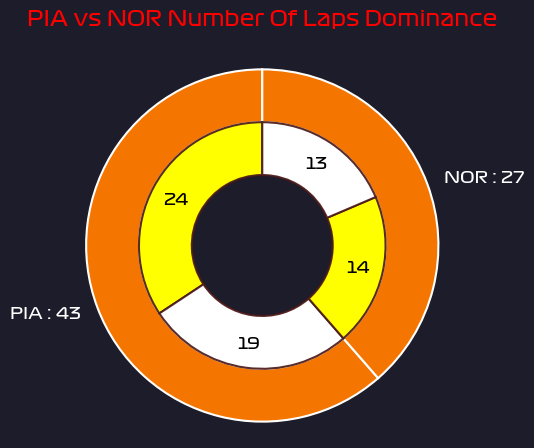

In [12]:
class LapTimeAnalysis:
    def __init__(self, df, driver_1, driver_2, results_df, font):
        self.df = df
        self.driver_1 = driver_1.upper()
        self.driver_2 = driver_2.upper()
        self.results_df = results_df
        self.font = font
        
        self.df['Seconds'] = pd.to_timedelta(df['LapTime']).dt.total_seconds()
        
        self.drv1_tel_data = self.df.pick_driver(self.driver_1.upper()).get_telemetry().add_distance()
        self.drv1_data = self.df.pick_driver(self.driver_1.upper())
        self.drv1_color = "#" + str(self.results_df[self.results_df['Abbreviation'] == self.driver_1.upper()]['TeamColor'].values[0])
        
        self.drv2_tel_data = self.df.pick_driver(self.driver_2.upper()).get_telemetry().add_distance()    
        self.drv2_data = self.df.pick_driver(self.driver_2.upper())
        self.drv2_color = "#" + str(self.results_df[self.results_df['Abbreviation'] == self.driver_2.upper()]['TeamColor'].values[0])
        
    def __assign_and_clean_telemetry(self, data_df, telemetry_df):
        
        data_df['LapStartTime'] = data_df['LapStartTime'].astype('timedelta64[ns]')
        data_df['LapTime'] = data_df['LapTime'].astype('timedelta64[ns]')
        data_df['LapEndTime'] = data_df['LapStartTime'] + data_df['LapTime']
        lap_numbers = []

        for index, row in telemetry_df.iterrows():
            lap_found = False
            for _, lap in data_df.iterrows():
                if lap['LapStartTime'] <= row['SessionTime'] <= lap['LapEndTime']:
                    lap_numbers.append(lap['LapNumber'])
                    lap_found = True
                    break
            if not lap_found:
                lap_numbers.append(None)

        telemetry_df['LapNumber'] = lap_numbers
                
        # 1. Select only the required columns
        selected_cols = ['LapNumber', 'X', 'Speed', 'nGear', 'Brake', 'RPM', 'Throttle']
        filtered_df = telemetry_df[selected_cols].copy()

        # 2. Define function to drop rows with very close X values within a lap
        def drop_close_x_rows(filtered_df, tolerance=0.01):
            cleaned_rows = []
            prev_x = None
            for _, row in filtered_df.iterrows():
                x = row['X']
                if prev_x is None or abs(x - prev_x) > tolerance:
                    cleaned_rows.append(row)
                    prev_x = x
            return pd.DataFrame(cleaned_rows)

        # 3. Apply function to each lap group
        cleaned_tel_df = (
            filtered_df
            .groupby('LapNumber', group_keys=False)
            .apply(drop_close_x_rows)
        )

        # 4. Sort by LapNumber and X
        cleaned_tel_df = cleaned_tel_df.sort_values(['LapNumber', 'X']).reset_index(drop=True)
        return telemetry_df  
    
    def get_sector_time_comparison(self):
        drv1_laptime = self.drv1_data['Seconds'].tolist()
        drv2_laptime = self.drv2_data['Seconds'].tolist()
        
        fig, ax = plt.subplots(figsize=(50, 25))
        fig.set_facecolor('#1C1C2A')
        ax.set_facecolor('#1C1C2A')
        
        ax.plot(self.drv1_data['LapNumber'].tolist(), drv1_laptime, color=self.drv1_color, linewidth=2)
        ax.plot(self.drv2_data['LapNumber'].tolist(), drv2_laptime, color=self.drv2_color, linewidth=2)

        ax.set_title(f"{self.driver_1} vs {self.driver_2} Lap Times", fontproperties = self.font, fontsize=50, color='red', pad=20)
         
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontproperties(self.font)  
            label.set_color("white")
            
        for spine in ax.spines.values():
            spine.set_visible(False)
           
        ax.set_xlabel("Lap Number", fontproperties = self.font, fontsize=25, color='white', labelpad=20)
        ax.set_ylabel("Lap Time (s)", fontproperties = self.font, fontsize=25, color='white', labelpad=20)               
        ax.tick_params(axis='both', colors='white', labelsize=25)  # X and Y-axis tick labels
        
        ax.set_ylim(74, 80)
        ax.legend([self.driver_1, self.driver_2])
        ax.grid(True, alpha=0.2)
        
        return fig
    
    def get_average_lap_speed(self):
                
        drv1_tel_data = self.__assign_and_clean_telemetry(self.drv1_data, self.drv1_tel_data)
        drv2_tel_data = self.__assign_and_clean_telemetry(self.drv2_data, self.drv2_tel_data)
        
        drv1_avg_speed = drv1_tel_data.groupby('LapNumber')['Speed'].mean().reset_index()
        drv2_avg_speed = drv2_tel_data.groupby('LapNumber')['Speed'].mean().reset_index()
        
        fig, ax = plt.subplots(figsize=(50, 20))
        fig.set_facecolor('#1C1C2A')
        ax.set_facecolor('#1C1C2A')
         
        # Plot the data
        ax.plot(drv1_avg_speed['LapNumber'], drv1_avg_speed['Speed'], color=self.drv1_color, linewidth=5)
        ax.plot(drv2_avg_speed['LapNumber'], drv2_avg_speed['Speed'], color=self.drv2_color, linewidth=5)
        ax.fill_between(drv2_avg_speed['LapNumber'], drv2_avg_speed['Speed'], drv1_avg_speed['Speed'], color='#A5DDFF', alpha = 0.5)

        ax.set_title(f"{self.driver_1} vs {self.driver_2} Average Lap Speed", fontproperties = self.font, fontsize=30, weight='bold', color='red', pad=20) 
        
        ax.tick_params(axis='both', colors='white', labelsize=30)  # X and Y-axis tick labels
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontproperties(self.font)
            tick.set_fontsize(20)
            
        # Remove border spines
        for spine in ax.spines.values():
            spine.set_visible(False)
            
        ax.set_xticks(range(1, 71, 2))
        ax.set_xlabel("Lap Number", fontsize=20, fontproperties = self.font, color = 'white', labelpad=20)
        ax.set_ylabel("Average Speed (kM/H)", fontsize=20, fontproperties = self.font, color = 'white', labelpad=20)
        ax.set_xlim(0, 72)
        ax.set_ylim(150, 220)
        
        ax.legend([self.driver_1, self.driver_2], fontsize=20, loc='upper left', bbox_to_anchor=(1, 1), prop = self.font)
        ax.grid(True, alpha=0.5)
        ax.grid(False, axis='x')
        
        return fig
    
    def overall_laptime_dominance(self):
        drv1_faster = 0
        drv2_faster = 0 
        drv1_counts = {'SOFT': 0, 'MEDIUM': 0, 'HARD': 0, 'INTERMEDIATE': 0, 'WET': 0}
        drv2_counts = {'SOFT': 0, 'MEDIUM': 0, 'HARD': 0, 'INTERMEDIATE': 0, 'WET': 0}
        compound_colors = {
                'SOFT': '#FF3333',         # Red
                'MEDIUM': '#FFFF00',       # Yellow
                'HARD': '#FFFFFF',         # White
                'INTERMEDIATE': '#00FF00', # Green
                'WET': '#0000FF'           # Blue
            }

        for (_, drv1), (_, drv2) in zip(self.drv1_data.iterrows(), self.drv2_data.iterrows()):
            if drv1['Seconds'] < drv2['Seconds']:
                drv1_faster += 1
                compound = drv1['Compound']
                if compound in drv1_counts:
                    drv1_counts[compound] += 1
            elif drv1['Seconds'] > drv2['Seconds']:
                drv2_faster += 1
                compound = drv2['Compound']
                if compound in drv2_counts:
                    drv2_counts[compound] += 1
                
        fig, ax = plt.subplots(figsize=(5, 5))
        fig.set_facecolor('#1C1C2A')
        ax.set_facecolor('#1C1C2A')
        
        # Plot Pie
        labels = [f"{self.driver_1} : {drv1_faster}", f"{self.driver_2} : {drv2_faster}"]
        size = 0.3
        wedge, texts =ax.pie([drv1_faster, drv2_faster], 
                             labels=labels, colors=[self.drv1_color, self.drv2_color], startangle=90,
                             wedgeprops=dict(width=size, edgecolor='w', linewidth=1.5)
                        )
        for text in texts:
            text.set_fontproperties(self.font)
            text.set_color('white')         
            text.set_fontsize(12)           
            text.set_weight('bold')         
            
        # Construct inner labels
        compound_order = list(drv1_counts.keys()) * 2  # ['SOFT', ..., 'WET', 'SOFT', ..., 'WET']
        combined_tyre_data = list(drv1_counts.values()) + list(drv2_counts.values())

        # Filter out zero lap entries and store compound info
        filtered_data = []
        for driver_idx, outer_value in enumerate([drv1_faster, drv2_faster]):
            for i, (value, compound) in enumerate(zip(
                combined_tyre_data[driver_idx * len(drv1_counts):(driver_idx + 1) * len(drv1_counts)],
                compound_order[driver_idx * len(drv1_counts):(driver_idx + 1) * len(drv1_counts)]
            )):
                if value > 0:
                    filtered_data.append((value, compound))

        # Extract inner ring details
        inner_values = []
        inner_labels = []
        inner_colors = []

        for value, compound in filtered_data:
            inner_values.append(value)
            inner_labels.append(f"{value}")  # 👉 show lap count instead of percentage
            inner_colors.append(compound_colors[compound])

        # Draw the inner pie chart
        wedges, labels = ax.pie(
            inner_values,
            radius=1 - size,
            labels=inner_labels,
            labeldistance=0.8,
            wedgeprops=dict(width=size, edgecolor="#4B1919EB", linewidth=1.5),
            colors=inner_colors,
            startangle=90
        )
        for text in labels :
            text.set_fontproperties(self.font)
            text.set_color('black')         
            text.set_fontsize(12)           
            text.set_weight('bold') 
        # Fix inner label position
        for string_label in labels:
            string_label.update({"rotation": 0, "horizontalalignment": "center", "verticalalignment": "center"})

        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        ax.set_title(f"{self.driver_1} vs {self.driver_2} Number Of Laps Dominance", fontproperties = self.font, fontsize=15, weight='bold', color='red', pad=20)
        
        return fig

    def lap_telemtry_comparision(self, lapnumber, data):
        # Prepare telemetry data with cleaned and assigned lap numbers
        try:
            drv1_lap_data = self.drv1_data[self.drv1_data['LapNumber'] == lapnumber]
            drv2_lap_data = self.drv2_data[self.drv2_data['LapNumber'] == lapnumber]
            
            if len(drv1_lap_data) == 0 or len(drv2_lap_data) == 0:
                raise ValueError(f"Lap {lapnumber} not found for one or both drivers")
                
        except KeyError:
            raise KeyError("'LapNumber' column missing in data")  # Stop if column doesn't exist
                    
        drv1_tel_data = drv1_lap_data.get_telemetry()
        drv2_tel_data = drv2_lap_data.get_telemetry()

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(50, 20))
        fig.set_facecolor('#1C1C2A')
        ax.set_facecolor('#1C1C2A')

        # Plot both drivers’ data
        ax.plot(drv1_tel_data['Distance'], drv1_tel_data[data], color=self.drv1_color, linewidth=5, label=self.driver_1)
        ax.plot(drv2_tel_data['Distance'], drv2_tel_data[data], color=self.drv2_color, linewidth=5, label=self.driver_2)

        # Tick customization
        ax.tick_params(axis='both', colors='white', labelsize=20)
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontproperties(self.font)
            tick.set_fontsize(20)

        # Remove border spines
        for spine in ax.spines.values():
            spine.set_visible(False)

        # Axis labels
        ax.set_xlabel("Distance", fontsize=30, fontproperties=self.font, color='#C5EBFF', labelpad=20)
        ax.set_ylabel(data, fontsize=30, fontproperties=self.font, color='#C5EBFF', labelpad=20)

        ax.set_xticks(range(0, 5000, 500))
        # Title
        ax.set_title(f"{data} Analysis - Lap {lapnumber}", fontproperties=self.font, fontsize=35, color='red', pad=30)

        # Grid setup
        ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
        ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.3, alpha=0.3)
        ax.minorticks_on()

        # Legend
        ax.legend(
            prop=self.font,
            fontsize=30,         # Text size
            loc='upper right',   # Legend position
            markerscale=2,       # Size of marker icons
            handlelength=3,      # Length of the legend lines
            borderpad=1.5,       # Padding inside the legend box
            frameon=True,        # Show the box
            labelspacing=1.2     # Vertical space between labels
        )

        return fig

    def track_dominance(self, lapnumber):
        # Prepare telemetry data with cleaned and assigned lap numbers
        try:
            drv1_lap_data = self.drv1_data[self.drv1_data['LapNumber'] == lapnumber]
            drv2_lap_data = self.drv2_data[self.drv2_data['LapNumber'] == lapnumber]
            
            if len(drv1_lap_data) == 0 or len(drv2_lap_data) == 0:
                raise ValueError(f"Lap {lapnumber} not found for one or both drivers")
                
        except KeyError:
            raise KeyError("'LapNumber' column missing in data")  # Stop if column doesn't exist
                
        drv1_tel_data = drv1_lap_data.get_telemetry()
        drv2_tel_data = drv2_lap_data.get_telemetry()      
        
        # Creating a track map 
        x_drv1 = drv1_tel_data['X'].values
        y_drv2 = drv1_tel_data['Y'].values 
        speed = drv1_tel_data['Speed'].values
        
        min_len = min(len(drv1_tel_data), len(drv2_tel_data))   # Gets the minimum length from both the telemetry data 
        x = drv1_tel_data['Y'].values[:min_len]  # Swap X and Y
        y = drv1_tel_data['X'].values[:min_len]
        
        drv1_speed = drv1_tel_data['Speed'].values[:min_len]
        drv2_speed = drv2_tel_data['Speed'].values[:min_len]
        
        colors = [self.drv1_color if d1 > d2 else 'magenta' for d1, d2 in zip(drv1_speed, drv2_speed)]
        
        # Step 1: Build segments from (x, y) points
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Step 2: Build line collection using the color list
        from matplotlib.collections import LineCollection
        lc = LineCollection(segments, colors=colors, linewidth=4)
                
        # Step 3: Plot the track
        fig, ax = plt.subplots(figsize=(15, 12))
        fig.set_facecolor('#1C1C2A')
        ax.set_facecolor('#1C1C2A')

        ax.add_collection(lc)
        ax.set_xlim(x.min() - 1000, x.max() + 1000)
        ax.set_ylim(y.min() - 1000, y.max() + 1000)
        ax.set_aspect('equal')
        ax.axis("off")   
        
        # Adding Text
        ax.text(
            15000 , 4000,
            self.driver_1,
            color = self.drv1_color,
            fontproperties=self.font,
            fontsize=10,
            ha = 'center',
            va = 'center'
        )
        ax.text(
            15000, 3750,
            "VS",
            color = 'white',
            fontproperties=self.font,
            fontsize=10,
            ha = 'center',
            va = 'center'
        )
        ax.text(
            15000 , 3500,
            self.driver_2,
            color = 'magenta',
            fontproperties=self.font,
            fontsize=10,
            ha = 'center',
            va = 'center'
        )
        # Drawing Box Around Driver Name 
        box_x = 14300     # Adjust to fit your text layout
        box_y = 3250
        box_width = 1500   # Increase if text overlaps
        box_height = 1000
        ha = 'center'
        va = 'center'

        # Draw the bounding box
        from matplotlib.patches import FancyBboxPatch
        box = FancyBboxPatch(
            (box_x, box_y),
            box_width,
            box_height,
            boxstyle="round,pad=250",
            linewidth=2.5,
            edgecolor='white',
            facecolor='#1C1C2A',
            alpha=0.6
        )

        ax.add_patch(box)
        ax.set_title(f"Performance trace comparison of lap {lapnumber}", color="#FFFFFF", fontproperties=self.font, weight = 'bold',  pad=20, fontsize=14)
        
        plt.tight_layout()
        plt.show()        
# Create instance
comparison = LapTimeAnalysis(df, 'PIA', 'NOR', results, regular_font) 

# Call the method you created
fig = comparison.overall_laptime_dominance()
if fig:
    fig.show()
else:
    print("No figure was generated. Check the lap number or data availability.")

    
    

In [14]:
schedule = fastf1.get_event_schedule(2025)

In [16]:
schedule.columns

Index(['RoundNumber', 'Country', 'Location', 'OfficialEventName', 'EventDate',
       'EventName', 'EventFormat', 'Session1', 'Session1Date',
       'Session1DateUtc', 'Session2', 'Session2Date', 'Session2DateUtc',
       'Session3', 'Session3Date', 'Session3DateUtc', 'Session4',
       'Session4Date', 'Session4DateUtc', 'Session5', 'Session5Date',
       'Session5DateUtc', 'F1ApiSupport'],
      dtype='object')

In [17]:
schedule.head(2)

,RoundNumber,Country,Location,OfficialEventName,EventDate,EventName,EventFormat,Session1,Session1Date,Session1DateUtc,...,Session3,Session3Date,Session3DateUtc,Session4,Session4Date,Session4DateUtc,Session5,Session5Date,Session5DateUtc,F1ApiSupport
0,0,Bahrain,Sakhir,FORMULA 1 ARAMCO PRE-SEASON TESTING 2025,2025-02-28,Pre-Season Testing,testing,Practice 1,2025-02-26 10:00:00+03:00,2025-02-26 07:00:00,...,Practice 3,2025-02-28 10:00:00+03:00,2025-02-28 07:00:00,None,NaT,NaT,None,NaT,NaT,True
1,1,Australia,Melbourne,FORMULA 1 LOUIS VUITTON AUSTRALIAN GRAND PRIX ...,2025-03-16,Australian Grand Prix,conventional,Practice 1,2025-03-14 12:30:00+11:00,2025-03-14 01:30:00,...,Practice 3,2025-03-15 12:30:00+11:00,2025-03-15 01:30:00,Qualifying,2025-03-15 16:00:00+11:00,2025-03-15 05:00:00,Race,2025-03-16 15:00:00+11:00,2025-03-16 04:00:00,True
